In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Creating 2 ways of feature representations



***NOTE***

-The timeslice length used here is 60 sec, which is proved to have good performance by paper

-$\vec{x_t^i}$ is a binary vector

-according to the paper, $y_t = j$ means the state(i.e. act) $j$ takes most of the 60 secs, even if there are other states(i.e. acts) happening during this 60 secs

-use different house data by setting house to A or B or C

In [23]:
timeslice = 60

In [31]:
#####
#select a house, 'A', 'B', or 'C'
#####
house = 'A'
act_df = pd.read_csv("house{}_act.csv".format(house))
sensor_df = pd.read_csv("house{}_sensor.csv".format(house))

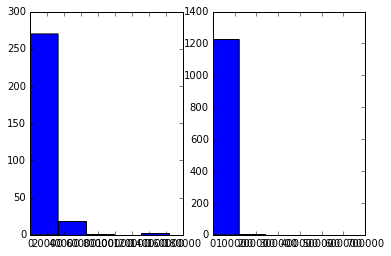

In [138]:
#check duration of activities or sensors
plt.subplot(1,2,1)
plt.hist(act_df.diff_sec, bins=5);
plt.subplot(1,2,2)
plt.hist(sensor_df.diff_sec, bins=5);

In [43]:
start = min(min(act_df.start_sec), min(sensor_df.start_sec))
end = max(max(act_df.end_sec), max(sensor_df.end_sec))
if (end-start)%timeslice != 0:
    end = (1+(end-start)/timeslice)*timeslice + start
duration = end-start

In [47]:
num_sensor = len(list(set(sensor_df.label)))
num_act = len(list(set(act_df.label)))
num_t = duration/timeslice
print "# sensors: ", num_sensor
print "# states/acts: ", num_act
print "# timeframes: ", num_t

# sensors:  14
# states/acts:  16
# timeframes:  40006


### Activity array

$y_t$ : activity at timeslice t 

0 means no activity

non-zero means labelled activity

In [54]:
Y = np.zeros(num_t)

In [62]:
i = 0
j = 0
while i < num_t and j < len(act_df):
    c = i*timeslice + start
    s = act_df.start_sec[j]
    t = act_df.end_sec[j]
    if c+timeslice < s:
        i+=1
    else:
        if c+timeslice < t:
            Y[i] = act_df.label[j]
            i+=1
        elif c+timeslice == t:
            Y[i] = act_df.label[j]
            j+=1
            i+=1
        else:
            if c+timeslice-t >= t-c:
                j+=1
            else:
                Y[i] = act_df.label[j]
                j+=1
                i+=1

In [120]:
np.sum(Y!=0), len(Y)

(32771, 40006)

### Representation 1: raw data

The raw sensor representation uses the sensor data directly as it was received from the sensors. It gives a 1 when the sensor is firing and a 0 otherwise.

**X_raw** is a num_t-by-num_sensor matrix, where rows are times and columns are features(or sensors). The maps of sensors to index can be found by the dictionary. 

In [93]:
#map from sensor to idx and idx to sensor
i2s = dict(zip(range(num_sensor), list(set(sensor_df.label))))
s2i = dict(zip(list(set(sensor_df.label)), range(num_sensor)))
s2i

{1.0: 0,
 5.0: 1,
 6.0: 2,
 7.0: 3,
 8.0: 4,
 9.0: 5,
 12.0: 6,
 13.0: 7,
 14.0: 8,
 17.0: 9,
 18.0: 10,
 20.0: 11,
 23.0: 12,
 24.0: 13}

In [114]:
#each row = (x1, x2, .. xn), n=num_sensor
X_raw = np.zeros([num_t, num_sensor])
for i in range(len(sensor_df)):
    elapsed = sensor_df.start_sec[i] - start
    row = elapsed/timeslice
    label = sensor_df.label[i]
    diff = sensor_df.diff_sec[i]
    while diff > 0:
        X_raw[row, s2i[label]] = 1
        row = row + 1
        diff = diff - timeslice

### Representation 2: changepoint

The change point representation indicates when a sensor event takes place. That is, it indicates when a sensor changes value. More formally, it gives a 1 when a sensor changes state (i.e. goes from zero to one or vice versa) and a 0 otherwise.

**X_change** is a num_t-by-num_sensor matrix, where rows are times and columns are features(or sensors). The maps of sensors to index can be found by the dictionary. 

In [112]:
X_change = np.zeros([num_t, num_sensor])
temp1 = np.zeros([num_t, num_sensor])
temp2 = np.zeros([num_t, num_sensor])

for i in range(len(sensor_df)):
    #for start point (from 0 to 1)
    row = (sensor_df.start_sec[i] - start)/timeslice
    label = sensor_df.label[i]
    temp1[row, s2i[label]] += 1 
    
    #for end point (from 1 to 0)
    row2 = (sensor_df.end_sec[i] - start)/timeslice
    #if ended in another time frame, we check the endpoint 
    if row2 != row:
        temp2[row2, s2i[label]] += 1

for i in range(num_t):
    for j in range(num_sensor):
        diff = abs(temp1[i,j]-temp2[i,j])
        if diff%2 == 1:
            X_change[i,j] = 1

In [117]:
a,b=0,0
for i in range(num_t):
    for j in range(num_sensor):
        if X_raw[i,j] == 1:
            a+=1
        if X_change[i,j] == 1:
            b+=1
print "ones in X_raw: ", a
print "ones in X_change: ", b

ones in X_raw:  52053
ones in X_change:  858
